#**PACKAGES**

In [1]:
!pip install PyWavelets > /dev/null 2>&1

In [2]:
import os
import math
import warnings
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from skimage.transform import resize
from skimage.metrics import mean_squared_error, structural_similarity as ssim
from skimage.restoration import denoise_nl_means, denoise_tv_chambolle, denoise_bilateral, denoise_wavelet

#**TASK 01 Image reading and displaying**

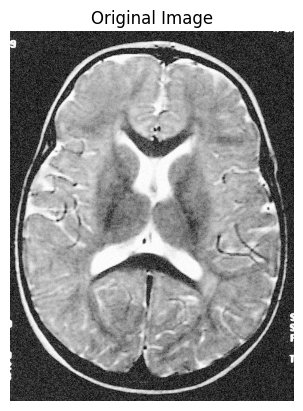

In [10]:
def print_header_information(width, height, magic_number, max_value):
    """
    The print_header_information function prints the basic header details of a PGM image.
    It takes four parameters —width, height, magic_number, and max_value—which represent the dimensions,
    format identifier (either 'P2' or 'P5'), and the maximum pixel value of the image. The function outputs
    these details to the console for user reference.
    """
    print(f"The magic number of the image is: {magic_number}")
    print(f"The height of the image is: {height}")
    print(f"The width of the image is: {width}")
    print(f"The max pixel value of the image is: {max_value}")

def maximum_value(max_value):
    """
    The `maximum_value` function checks if the provided `max_value` is a valid positive integer and follows the
    expected bit depth range. It verifies that the value is of the form ( 2^n - 1 ), which is typical for
    grayscale images (e.g., 255 for 8-bit, 65535 for 16-bit). If the value is invalid, it raises a `ValueError`.
    """
    if not isinstance(max_value, int) or max_value <= 0 or max_value != (2 ** (math.floor(math.log(max_value + 1, 2))) - 1):
        raise ValueError(f"Invalid or unsupported max pixel value: {max_value}. It should be a positive integer of the form 2^n - 1.")
    return True

def validate_pgm_pixel_data_Image(pixels, max_value):
    """
    The validate_pgm_pixel_data_Image function checks whether all pixel values in the provided pixels list fall
    within the valid range, from 0 to the max_value. It does this by iterating through each pixel value and ensuring
    that it is greater than or equal to 0 and less than or equal to the max_value. If any pixel value is out of this
    range, it raises a ValueError with a message indicating that the pixel values are invalid. If all values are valid,
    it returns True.
    """
    if not all(0 <= value <= max_value for value in pixels):
        raise ValueError(f"Pixel values exceed the maximum value of {max_value} or are below 0.")
    return True

def validate_pixel_count(pixel_count, pixels):
    """
    The check_line_length function checks if any line in the lines list exceeds a specified maximum length
    (max_length, default is 70 characters). It iterates through each line, counting how many lines exceed the
    maximum length. If any such lines are found, it triggers a warning with the count of these lines and indicates
    that they exceed the specified length. If no lines exceed the limit, no warning is issued. This helps to ensure
    the image file format follows the expected constraints.
    """
    if len(pixels) != pixel_count:
        raise ValueError(f"Expected {pixel_count} pixels, but found {len(pixels)}.")
    return True

def check_line_length(lines, max_length=70):
    """
    The check_line_length function checks if any line in the lines list exceeds a specified maximum length
    (max_length, default is 70 characters). It iterates through each line, counting how many lines exceed the
    maximum length. If any such lines are found, it triggers a warning with the count of these lines and indicates
    that they exceed the specified length. If no lines exceed the limit, no warning is issued. This helps to ensure
    the image file format follows the expected constraints.
    """
    warning_count = 0
    for line in lines:
        if len(line) > max_length:
            warning_count += 1
    if warning_count > 0:
        warnings.warn(f"{warning_count} line(s) exceed {max_length} characters")

def reshape_pixels_noisyImage(pixels, width, height):
    """
    This function uses list comprehension to reshape the pixel data. It iterates over the range of the height and
    slices the pixels list to create sublists of length width, effectively turning the flat pixel list into rows of
    pixel data. It returns a 2D list, where each sublist corresponds to a row in the image
    """
    return [pixels[i * width:(i + 1) * width] for i in range(height)]

def reshape_pixels(pixels, width, height):
    """
    This function does the same thing as reshape_pixels_noisyImage, but it uses a for loop to manually slice the pixel
    list. It calculates the start and end index for each row of the image (start_idx and end_idx) based on the current
    row index (i), then appends each row (a slice of the pixels list) to the image_data list.Finally, it returns the
    2D list (image_data) representing the reshaped image.
    """
    image_data = []
    for i in range(height):
        start_idx = i * width
        end_idx = start_idx + width
        image_data.append(pixels[start_idx:end_idx])
    return image_data

def apply_gamma_correction(pixels, max_value, gamma=2.2):
    """
    The apply_gamma_correction function adjusts the brightness of the image based on a gamma correction formula.
    It scales pixel values to the range [0, 1], applies the gamma correction, and then scales back to the original
    range. This helps in adjusting the brightness non-linearly, where gamma > 1 darkens the image, and gamma < 1
    lightens it
    """
    return [
        min(max_value, int((value / max_value) ** (1 / gamma) * max_value)) if value > 0 else 0
        for value in pixels
    ]

def read_pgm_header(lines, binary=False):
    """
    The read_pgm_header function reads the header information from a PGM (Portable Gray Map) file, either in ASCII or
     binary format, and extracts essential details like the image's width, height, and maximum pixel value (max_value).
    The function first extracts the width and height from the first line (converting them to integers), and max_value
    from the second line. If the file is in binary format (binary=True), it returns the pixel data starting from the
    third line.For ASCII format, it returns the remaining lines as pixel_lines, which contain the pixel values in
    textual format.This function helps in parsing the header of PGM files and prepares the image for further
    processing based on its type (binary or ASCII).
    """
    width, height = map(int, lines[0].split())
    max_value = int(lines[1])
    if binary:
        pixel_data = lines[2]
        return width, height, max_value, pixel_data
    pixel_lines = lines[2:]
    return width, height, max_value, pixel_lines

def read_binary_lines(image_file):
    """
    The read_binary_lines function reads the header of a binary PGM file, ignoring comment lines (those starting with
    '#'). It collects the first two header lines (containing image dimensions and max pixel value) and then reads the
    pixel data. It returns a list with the header information followed by the raw pixel data.
    """
    lines = []
    while True:
        line = image_file.readline().decode('utf-8').strip()
        if not line.startswith('#'):
            lines.append(line)
        if len(lines) == 2:
            break
    pixel_data = image_file.read()
    return lines + [pixel_data]

def process_pixels(pixels, max_value, width, height, pixel_count, image_type_noisy):
    """
    The process_pixels function validates the pixel data by checking if the maximum value is valid, if the pixel
    values are within the expected range, and if the number of pixels matches the expected count. After validation,
    it applies gamma correction to the pixel values and reshapes the pixel data into a 2D array, depending on whether
    the image is noisy. If any validation fails, it catches the error and prints a message. If validation passes, it
    returns the reshaped image data.
    """
    try:
        if maximum_value(max_value) and validate_pgm_pixel_data_Image(pixels, max_value) and validate_pixel_count(pixel_count, pixels):
            pixels = apply_gamma_correction(pixels, max_value)
            image_data = reshape_pixels_noisyImage(pixels, width, height) if image_type_noisy else reshape_pixels(pixels, width, height)
            return image_data
    except ValueError as e:
        print(f"Validation error: {e}")
        return None

def process_pgm_noisyImage(image_file, max_value, width, height, magic_number,apply_gamma=False, is_ascii=False):
    """
    The process_pgm_noisyImage function handles both ASCII and binary PGM files. It reads the pixel data based on the
    file type, decodes it, and checks the line length for ASCII files. Then, depending on the maximum pixel value
    (max_value), it converts the pixel data to an appropriate format. If max_value is 255, the pixel data is directly
    converted to integers, and if it's 65535, it handles two-byte pixel values. The function then calculates the total
    pixel count and passes the pixel data to process_pixels for further processing, including validation and reshaping.
    If an unsupported max pixel value is encountered, it raises an error.
    """
    if is_ascii:
        pixel_data = image_file.read().decode().strip().split()
        check_line_length(pixel_data)
        pixel_data = [int(value) for value in pixel_data]
    else:
        pixel_data = image_file.read()

    if max_value == 255:
        pixels = list(pixel_data)
    elif max_value == 65535:
        pixels = [int.from_bytes(pixel_data[i:i+2], byteorder='big') for i in range(0, len(pixel_data), 2)]
    else:
        raise ValueError(f"Unsupported max pixel value: {max_value}")

    pixel_count = width * height
    # print_header_information(width, height, magic_number, max_value)
    return process_pixels(pixels, max_value, width, height, pixel_count, True)

def display_image(image_data):
    """
    The display_image function displays an image using the matplotlib library. First, it checks if the
    image_data is None, raising a ValueError if no image data is provided. If valid image data is passed,
    it uses plt.imshow to display the image with a grayscale colormap (cmap='gray'). The plt.axis('off')
    hides the axis labels for a cleaner view. Finally, plt.show() is called to render and display the
    image on the screen.
    """
    if image_data is None:
        raise ValueError("No image data to display.")
    plt.imshow(image_data, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

def validate_pgm_file(file_path):
    """
    Validates if the given file is a PGM file based on its extension.
    Only files with a `.pgm` extension are allowed.
    """
    file_name, file_extension = os.path.splitext(file_path)
    if file_extension.lower() != '.pgm':
        raise ValueError(f"Only .pgm files are supported. The provided file has the extension: {file_extension}")
    return file_name

def image_read(image_path, apply_gamma=False):
    """
    The `image_read` function reads and processes a PGM image file based on its format (either ASCII or binary):
    1.Opening the File: It opens the image file in binary read mode (`'rb'`) and reads the first line of the header.
    2.Header Parsing: The first line (header) is split into components: `magic_number`, `width`, `height`, and `max_value`.
    The function checks that the magic number is either `P2` (ASCII) or `P5` (binary), which are the valid formats for PGM files.
    3.Processing the Image:
      - For a binary PGM file (`P5`), it calls `process_pgm_noisyImage` to process the image with binary data.
      - For an ASCII PGM file (`P2`), it similarly calls `process_pgm_noisyImage` to handle the image data in ASCII format.
    4.Error Handling: If the magic number is not supported or the header line exceeds 70 characters, it raises a `ValueError`.
    """
    with open(image_path, 'rb') as image_file:
        header_parts = []
        while len(header_parts) < 4:
            line = image_file.readline().decode().strip()
            if line.startswith('#') or not line:
                continue
            header_parts.extend(line.split())
            if len(line) > 70:
                raise ValueError(f"Header line exceeds the maximum length of 70 characters: {line}")
        magic_number = header_parts[0]
        if magic_number not in {'P2', 'P5'}:
            raise ValueError(f"Unsupported magic number: {magic_number}. Only P2 (ASCII) or P5 (Binary) PGM files are supported.")
        # print(header_parts)
        width = int(header_parts[1])
        height = int(header_parts[2])
        max_value = int(header_parts[3])
        if magic_number == 'P5':
            image_data = process_pgm_noisyImage(image_file, max_value, width, height, magic_number, apply_gamma, is_ascii=False)
        elif magic_number == 'P2':
            image_data = process_pgm_noisyImage(image_file, max_value, width, height, magic_number, apply_gamma, is_ascii=True)
        return image_data

def process_image(file_path, apply_gamma=False):
    """
    The `process_image` function validates the input PGM file and processes it accordingly. It first checks if the file
    has a valid `.pgm` extension using the `validate_pgm_file` function. If valid, it reads and processes the image
    using `image_read`, optionally applying gamma correction. If the image is successfully processed, it is
    displayed using the `display_image` function. If any errors occur during validation or processing (e.g., invalid
    file format or pixel data), an error message is printed, and the function returns `None`.
    """
    try:
        file_name = validate_pgm_file(file_path)
        # print(f"Processing file: {file_name}")
        image_data = image_read(file_path, apply_gamma)
        if image_data is not None:
            display_image(image_data)
        else:
            print("Image validation failed. No image to display.")
    except ValueError as e:
        print(f"Error: {e}")
    return image_data

pgm_path = '/content/Brain1_noisy1.pgm'
result = process_image(pgm_path, apply_gamma=True)

#**TASK 02 Wavelet decomposition**

##**2.1 Forward Discrete Wavelet Transform**

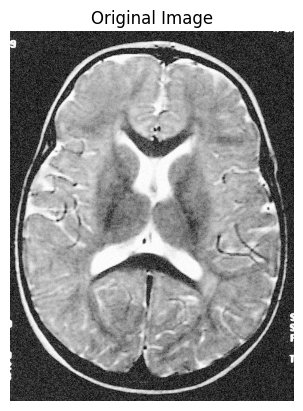

In [4]:
#ref : https://www.researchgate.net/publication/228936354_Length-preserving_wavelet_transform_algorithms_for_zero-padded_and_linearly-extended_signals

def pad_to_even_dimensions(data):
    """
    Pads the input 2D array 'data' to ensure that both dimensions (rows and columns)
    are even. This is necessary for certain image processing techniques, such as the
    Discrete Wavelet Transform (DWT), which often requires images to have even dimensions
    for the algorithm to work properly.

    Parameters:
    - data: 2D NumPy array (image or matrix) that may have odd dimensions in either
            rows or columns.

    Returns:
    - A tuple consisting of:
      1. The padded 2D array (data), which will have even dimensions in both axes.
      2. The original shape of the data as a tuple, which is useful for reversing
         the padding later if needed.

    How it works:
    - If the number of rows is odd, it adds an extra row filled with zeros.
    - If the number of columns is odd, it adds an extra column filled with zeros.
    - This ensures that the image or matrix has even dimensions (both rows and columns).
    """
    rows, cols = data.shape
    original_shape = data.shape
    if rows % 2 != 0:
        data = np.vstack((data, np.zeros((1, cols))))
    if cols % 2 != 0:
        data = np.hstack((data, np.zeros((data.shape[0], 1))))
    return data, original_shape

def haar_wavelet_filter_1d(data):
    """
     Performs the 1D Haar wavelet transform on the input data.
    The Haar wavelet transform is a simple, first-generation wavelet transform
    that splits a signal into two components: an approximation (low-pass filter)
    and a detail (high-pass filter). This function performs a single level of the
    transform, where the input signal is divided into even and odd indexed parts.

    Parameters:
    - data: 1D NumPy array (input signal or data) to be transformed.

    Returns:
    - low_pass: 1D array containing the approximation (low-frequency components)
                of the signal after the Haar transform.
    - high_pass: 1D array containing the detail (high-frequency components)
                 of the signal after the Haar transform.

    How it works:
    1. First, the function checks if the length of the input data is even. If it is odd,
       the last element is removed to make the length even. This is necessary for
       the Haar transform to work correctly.
    2. The input data is then divided into two parts:
        - The approximation (low-pass) part, which represents the smoothed,
          low-frequency components of the signal.
        - The detail (high-pass) part, which represents the high-frequency,
          fine details of the signal.
    3. Both parts are computed by pairing up consecutive elements and combining
       them in a particular way:
        - The approximation is the average of adjacent elements.
        - The detail is the difference between adjacent elements.
    4. Both approximation and detail components are normalized by dividing by
       the square root of 2, which is a standard normalization factor
       in wavelet transforms.
    """
    length = len(data)
    if length % 2 != 0:
        data = data[:-1]
        length -= 1
    half = length // 2
    low_pass = (data[::2] + data[1::2]) / np.sqrt(2)
    high_pass = (data[::2] - data[1::2]) / np.sqrt(2)
    return low_pass, high_pass

def fdwt(image_data, wavelet_level=3):
    """
    Performs the Forward Discrete Wavelet Transform (FDWT) on the input image data.
    This function applies the Haar wavelet transform on both rows and columns of
    the image data iteratively for a specified number of levels.

    The FDWT decomposes the image into several sub-band components that represent
    different frequency bands (approximation, horizontal, vertical, and diagonal).

    Parameters:
    - image_data: 2D NumPy array (image data) to be transformed.
    - wavelet_level: The number of levels of decomposition to perform.

    Returns:
    - approximation: The approximation of the image after wavelet transformation.
    - decomposition: A list of tuples, each containing the four sub-band components
      (approximation, horizontal, vertical, diagonal) for each level of decomposition.
    - original_shape: The original shape of the input image data (before padding).

    How it works:
    1. Padding the Image: The input image is padded to ensure that both dimensions
       (rows and columns) are even, which is required for the Haar wavelet transform.
    2. Decomposition at Each Level:
       - At each level, the approximation image is decomposed into four sub-bands:
         - Approximation (low-frequency content, kept for the next level).
         - Horizontal (captures horizontal details).
         - Vertical(captures vertical details).
         - Diagonal(captures diagonal details).
    3. Applying Haar Wavelet: The Haar wavelet transform is applied to both rows and columns of the image. This transforms the image into low-pass and high-pass components for both row and column directions.
    4. Iteration for Multiple Levels: The approximation part of the image is further decomposed for the specified number of levels, and the decomposition results are stored.
    5. Return: The function returns the final approximation, the decomposition list containing sub-bands for each level, and the original shape of the image.
    """
    padded_image, original_shape = pad_to_even_dimensions(image_data)
    approximation = np.copy(padded_image)
    decomposition = []
    for level in range(wavelet_level):
        rows, cols = approximation.shape
        transformed = np.zeros((rows, cols))
        for i in range(rows):
            low_pass, high_pass = haar_wavelet_filter_1d(approximation[i, :])
            half_cols = len(low_pass)
            transformed[i, :half_cols] = low_pass
            transformed[i, half_cols:half_cols + len(high_pass)] = high_pass
        for j in range(cols):
            low_pass, high_pass = haar_wavelet_filter_1d(transformed[:, j])
            half_rows = len(low_pass)
            transformed[:half_rows, j] = low_pass
            transformed[half_rows:half_rows + len(high_pass), j] = high_pass
        approx = transformed[:rows // 2, :cols // 2]
        horiz = transformed[:rows // 2, cols // 2:]
        vert = transformed[rows // 2:, :cols // 2]
        diag = transformed[rows // 2:, cols // 2:]
        decomposition.append((approx, horiz, vert, diag))
        approximation = approx
    return approximation, decomposition, original_shape

pgm_path = '/content/Brain1_noisy1.pgm'
original_image_data = process_image(pgm_path, apply_gamma=True)
image_data_array = np.array(original_image_data)
# print(image_data_array.shape)
# print("Image data array contents:", image_data_array)
approximation, decomposition ,original_shape = fdwt(image_data_array, wavelet_level=3)

##**2.2 Levels Of Decomposition**

Level 1 Shapes:
  Approximation (A1): (456, 350)
  Horizontal Details (H1): (456, 350)
  Vertical Details (V1): (456, 350)
  Diagonal Details (D1): (456, 350)


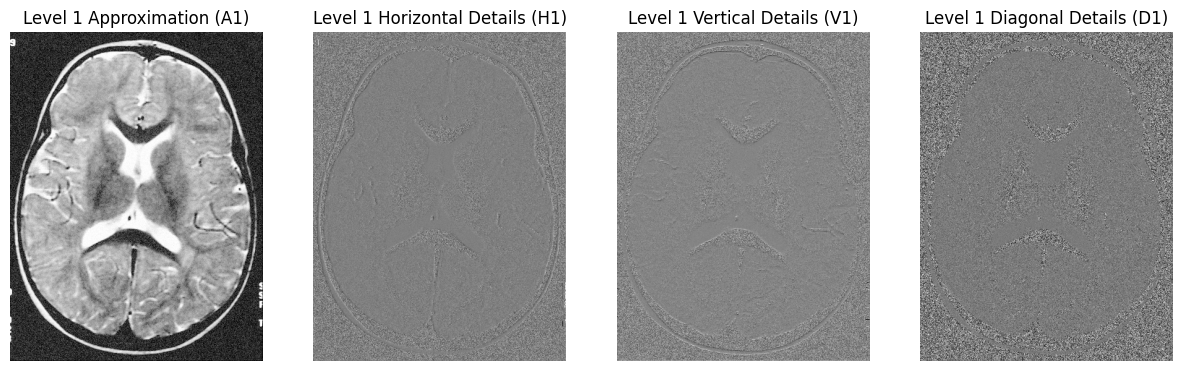

Level 2 Shapes:
  Approximation (A2): (228, 175)
  Horizontal Details (H2): (228, 175)
  Vertical Details (V2): (228, 175)
  Diagonal Details (D2): (228, 175)


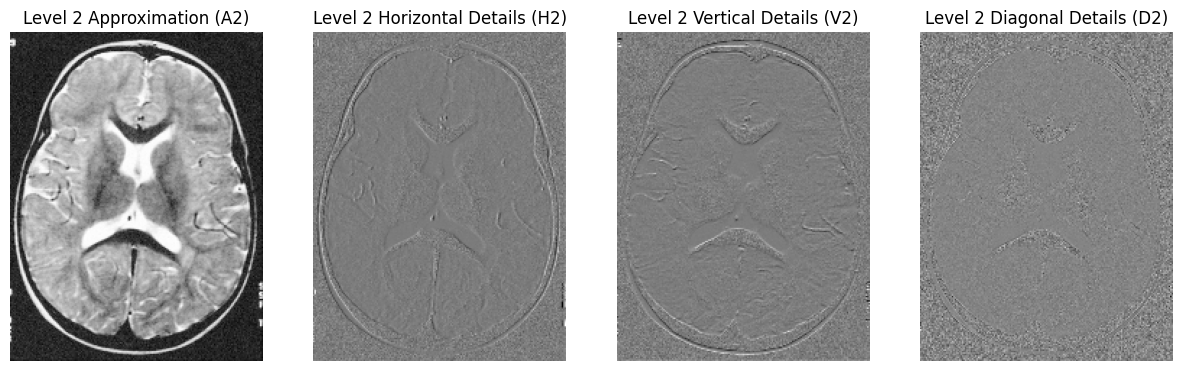

Level 3 Shapes:
  Approximation (A3): (114, 87)
  Horizontal Details (H3): (114, 88)
  Vertical Details (V3): (114, 87)
  Diagonal Details (D3): (114, 88)


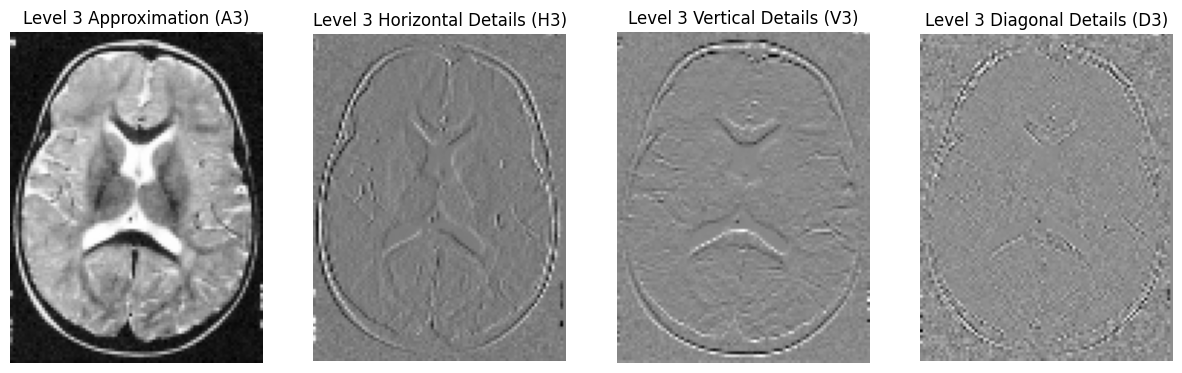

In [5]:
for level in range(len(decomposition)):
    """
      Loop over the decomposition list to visualize each level's sub-bands (approximation, horizontal, vertical, diagonal).
      For each level, we will display the four components of the Discrete Wavelet Transform (DWT) in subplots.

      1. Approximation: The low-frequency component that contains the smooth features of the image.
      2. Horizontal Details: The high-frequency component that highlights horizontal edges.
      3. Vertical Details: The high-frequency component that highlights vertical edges.
      4. Diagonal Details: The high-frequency component that highlights diagonal edges.

      Each sub-band is displayed using the 'imshow' function with a grayscale color map.
      Axis labels and ticks are turned off for a cleaner visual presentation.
     """
    approx, horiz, vert, diag = decomposition[level]
    print(f"Level {level+1} Shapes:")
    print(f"  Approximation (A{level+1}): {approx.shape}")
    print(f"  Horizontal Details (H{level+1}): {horiz.shape}")
    print(f"  Vertical Details (V{level+1}): {vert.shape}")
    print(f"  Diagonal Details (D{level+1}): {diag.shape}")

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(approx, cmap='gray')
    axes[0].set_title(f"Level {level+1} Approximation (A{level+1})")
    axes[0].axis('off')
    axes[1].imshow(horiz, cmap='gray')
    axes[1].set_title(f"Level {level+1} Horizontal Details (H{level+1})")
    axes[1].axis('off')
    axes[2].imshow(vert, cmap='gray')
    axes[2].set_title(f"Level {level+1} Vertical Details (V{level+1})")
    axes[2].axis('off')
    axes[3].imshow(diag, cmap='gray')
    axes[3].set_title(f"Level {level+1} Diagonal Details (D{level+1})")
    axes[3].axis('off')
    plt.show()

##**2.3 Inverse Discrete Wavelet Transform**

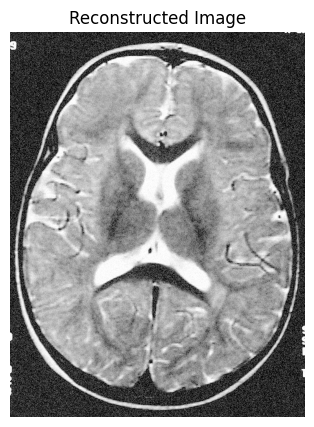

In [6]:
def inverse_haar_wavelet_filter_1d(low_pass, high_pass):
    """
    Apply the inverse Haar wavelet filter in 1D to combine the low-pass and high-pass components.

    The function reconstructs the original signal by combining the low and high frequency components
    of the signal. The reconstruction is done by reversing the Haar transform, which is an averaging
    and differencing operation.

    Args:
        low_pass (numpy.ndarray): The low-frequency component (approximations).
        high_pass (numpy.ndarray): The high-frequency component (details).

    Returns:
        numpy.ndarray: The combined signal reconstructed from the low and high pass components.
    """
    combined = np.zeros((low_pass.size + high_pass.size,))
    combined[::2] = (low_pass + high_pass) / np.sqrt(2)
    combined[1::2] = (low_pass - high_pass) / np.sqrt(2)
    return combined


def inverse_haar_wavelet_filter_2d(image_data):
    """
    Apply the inverse Haar wavelet filter in 2D to reconstruct the image.

    This function performs the inverse wavelet transform by applying the 1D inverse Haar filter
    to both rows and columns of the image data. The rows and columns are updated iteratively
    to reconstruct the original image from its wavelet decomposition.

    Args:
        image_data (numpy.ndarray): The image data (2D array) after wavelet decomposition.

    Returns:
        numpy.ndarray: The 2D array with the reconstructed image.
    """
    rows, cols = image_data.shape
    half_rows, half_cols = rows // 2, cols // 2
    for col in range(cols):
        low_pass = image_data[:half_rows, col]
        high_pass = image_data[half_rows:, col]
        image_data[:, col] = inverse_haar_wavelet_filter_1d(low_pass, high_pass)
    for row in range(rows):
        low_pass = image_data[row, :half_cols]
        high_pass = image_data[row, half_cols:]
        image_data[row, :] = inverse_haar_wavelet_filter_1d(low_pass, high_pass)
    return image_data


def idwt(decomposition, approximation, original_shape):
    """
    Perform the Inverse Discrete Wavelet Transform (IDWT) to reconstruct the image.

    This function applies the inverse of the wavelet transform, which reconstructs the image
    from its decomposition (approximation, horizontal, vertical, and diagonal sub-bands).
    It iterates over the decomposition levels in reverse order, combining the approximation
    and details at each level to reconstruct the image.

    Args:
        decomposition (list): List of decomposition levels, each containing (approximation, horiz, vert, diag).
        approximation (numpy.ndarray): The approximation at the last decomposition level.
        original_shape (tuple): The original shape of the image before transformation.

    Returns:
        numpy.ndarray: The reconstructed image after applying IDWT.
    """
    for approx, horiz, vert, diag in reversed(decomposition):
        rows, cols = approximation.shape
        horiz = horiz[:rows, :cols]
        vert = vert[:rows, :cols]
        diag = diag[:rows, :cols]
        temp = np.zeros((rows * 2, cols * 2))
        temp[:rows, :cols] = approximation
        temp[:rows, cols:cols + horiz.shape[1]] = horiz
        temp[rows:rows + vert.shape[0], :cols] = vert
        temp[rows:rows + diag.shape[0], cols:cols + diag.shape[1]] = diag
        approximation = inverse_haar_wavelet_filter_2d(temp)
    reconstructed_image = approximation[:original_shape[0], :original_shape[1]]
    return reconstructed_image

reconstructed_image = idwt(decomposition, approximation, original_shape)
plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()

In [7]:
def mse(original, reconstructed):
    """
    Calculate the Mean Squared Error (MSE) between two images with potential dimension mismatch.

    Args:
        original (numpy.ndarray): The original image data.
        reconstructed (numpy.ndarray): The reconstructed image data.

    Returns:
        float: The Mean Squared Error between the two images.
    """
    min_rows = min(original.shape[0], reconstructed.shape[0])
    min_cols = min(original.shape[1], reconstructed.shape[1])
    original_cropped = original[:min_rows, :min_cols]
    reconstructed_cropped = reconstructed[:min_rows, :min_cols]
    squared_difference = (original_cropped - reconstructed_cropped) ** 2
    mse_value = np.mean(squared_difference)
    # mse_value = mean_squared_error(original_cropped.ravel(), reconstructed_cropped.ravel())
    return mse_value

#images are normalized
image_data_array = (image_data_array - np.min(image_data_array)) / (np.max(image_data_array) - np.min(image_data_array))
reconstructed_image = (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image))

# Calculate MSE
error = mse(image_data_array, reconstructed_image)

# Print error in two formats
print(f"Mean Squared Error (MSE) between original and reconstructed image: {error:.8f}")
print(f"Mean Squared Error (MSE) between original and reconstructed image: {error:.8e}")

Mean Squared Error (MSE) between original and reconstructed image: 0.00000000
Mean Squared Error (MSE) between original and reconstructed image: 2.15142876e-31


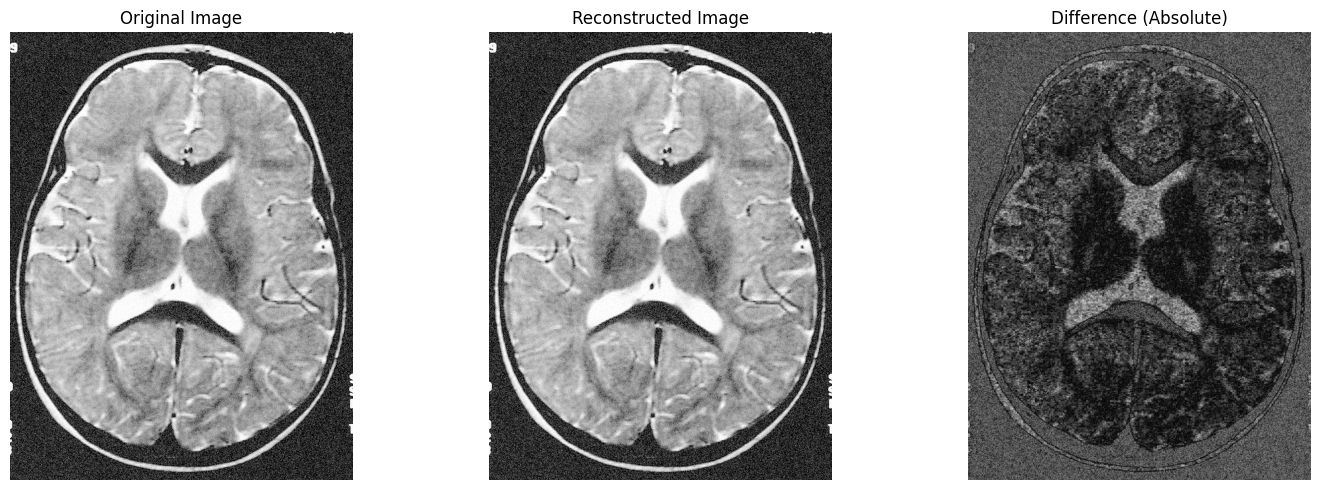

In [8]:
def visualize_difference(original_image, reconstructed_image):
    """
    Visualize the difference between the original and reconstructed images.

    This function displays three images side by side:
    - The original image
    - The reconstructed image
    - The absolute difference between the original and reconstructed images

    The absolute difference is calculated pixel-wise, and it highlights the discrepancies between the two images.

    Args:
        original_image (numpy.ndarray): The original image data.
        reconstructed_image (numpy.ndarray): The reconstructed image data.
    """
    min_rows = min(original_image.shape[0], reconstructed_image.shape[0])
    min_cols = min(original_image.shape[1], reconstructed_image.shape[1])
    original_cropped = original_image[:min_rows, :min_cols]
    reconstructed_cropped = reconstructed_image[:min_rows, :min_cols]
    diff_image = np.abs(original_cropped - reconstructed_cropped)
    plt.figure(figsize=(15, 5))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_cropped, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_cropped, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')

    # Display the absolute difference image
    plt.subplot(1, 3, 3)
    plt.imshow(diff_image, cmap='gray')
    plt.title("Difference (Absolute)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# `image_data_array` is the original image and `reconstructed_image` is obtained after IDWT
visualize_difference(image_data_array, reconstructed_image)

# **TASK 03: Image denoising**

+--------------+--------------------+
|    Metric    |       Value        |
+--------------+--------------------+
| Best Weights |  (0.5, 0.0, 0.5)   |
|  Best SSIM   | 0.7574275287343166 |
+--------------+--------------------+
+--------------------+-----------------------+--------------------+
|       Method       |          MSE          |        SSIM        |
+--------------------+-----------------------+--------------------+
| Combined Denoising | 0.0031933633182275956 | 0.7574275287343166 |
| Wavelet Denoising  | 0.008710395409103315  | 0.6324169278188326 |
|    Mean Filter     | 0.0017560845447094685 | 0.7159367709964376 |
|   Median Filter    | 0.004378571634283249  | 0.630851581171888  |
|     VisuShrink     | 0.004138851776601271  | 0.6799951713676147 |
+--------------------+-----------------------+--------------------+


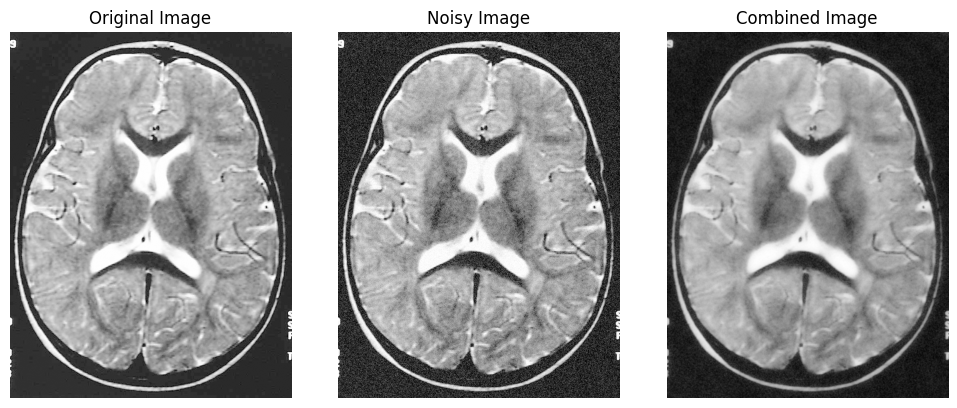

In [9]:
def resize_images_to_same_shape(images, target_shape):
    """
    Resize a list of images to a specified target shape.

    Parameters:
    -----------
    images : list of ndarray
        A list containing images (numpy arrays) to be resized.
    target_shape : tuple
        The desired shape (height, width) to resize all images to.

    Returns:
    --------
    resized_images : list of ndarray
        A list containing images resized to the target shape.

    Notes:
    ------
    - If an image already has the target shape, it is added to the output list as-is.
    - The resizing uses anti-aliasing for better quality, and the 'reflect' mode handles
      boundaries to prevent artifacts during resizing.
    """
    resized_images = []
    for img in images:
        if img.shape != target_shape:
            img_resized = resize(img, target_shape, mode='reflect', anti_aliasing=True)
        else:
            img_resized = img
        resized_images.append(img_resized)
    return resized_images

def mean_filter(noisy_image, size=3):
    """
    Denoise an image using a mean filter.

    This function applies a mean filter to the noisy image to reduce noise by averaging the pixel values
    in a local neighborhood around each pixel. It works by sliding a square window of size 'size' over
    the entire image and replacing each pixel with the mean value of the pixels in that window.

    Parameters:
    noisy_image (numpy.ndarray): The input noisy image, a 2D array of pixel values.
    size (int): The size of the filter window, which is typically an odd integer (default is 3).

    Returns:
    numpy.ndarray: The denoised image, where each pixel is replaced by the mean of its local neighborhood.
    """
    padded_image = np.pad(noisy_image, size // 2, mode='reflect')
    denoised_image = np.zeros_like(noisy_image)
    for i in range(noisy_image.shape[0]):
        for j in range(noisy_image.shape[1]):
            window = padded_image[i:i+size, j:j+size]
            denoised_image[i, j] = np.mean(window)
    return denoised_image

def estimate_noise(coefficients):
    """
    Estimate noise standard deviation from wavelet coefficients.
    Formula : σ = Median(|Subband|)/0.645
    """
    return np.median(np.abs(coefficients)) / 0.6745

def visu_shrink_thresholding(coefficients, noise_std):
    """
    VisuShrink wavelet thresholding (Universal threshold) using soft thresholding.

    Parameters:
        coefficients (ndarray): Wavelet coefficients.
        noise_std (float): (σ) Standard deviation of the noise.

    Returns:
        ndarray: Thresholded wavelet coefficients.

    Algorithm:
      1. Convert the image in frequency domain
      2. estimate the threshold value
          Formula : T = σ * √ 2 log M
            T = Universal Threshold
            σ = noise variance
            M = number of pixels
      3. Apply soft thresholding
      4. Reconstruct image form frequency domain

    Reference :
      P. L. Parmar, "Image Denoising Using VisuShrink Algorithm," Journal of Information, Knowledge and Research in
      Electronics and Communication Engineering, vol. 2, no. 2, pp. 762, Nov. 2012–Oct. 2013
    """
    threshold = noise_std * np.sqrt(2 * np.log(len(coefficients.flatten())))
    return np.sign(coefficients) * np.maximum(np.abs(coefficients) - threshold, 0)

def predefined_wavelet_denoising(noisy_image, method='VisuShrink', wavelet='Haar', mode='soft'):
    """
    Perform wavelet denoising using predefined methods.

    Parameters:
        noisy_image (ndarray): Input noisy image.
        method (str): Denoising method ('VisuShrink').
        wavelet (str): Type of wavelet to use ('haar').
        mode (str): Thresholding mode ('soft').

    Returns:
        ndarray: Denoised image.
    """
    denoised_image = denoise_wavelet(noisy_image,method=method,mode=mode, wavelet=wavelet,rescale_sigma=True)
    return denoised_image

def calculate_dynamic_threshold_factor(noisy_image, decomposition, wavelet_level=3):
    """
    Calculate the dynamic threshold factor based on the decomposition coefficients
    and the noise standard deviation of the noisy image.

    Parameters:
    -----------
    noisy_image : ndarray
        The input noisy image represented as a NumPy array.
    decomposition : list of tuples
        The wavelet decomposition of the image, where each tuple contains wavelet
        coefficients (approximation and detail coefficients).
    wavelet_level : int, optional
        The level of wavelet decomposition used (default is 3).

    Returns:
    --------
    threshold_factor : float
        The calculated threshold factor to be used in wavelet thresholding (VisuShrink).

    Notes:
    ------
    The threshold factor is computed by first estimating the noise standard deviation
    from the noisy image and then calculating a dynamic threshold based on the number
    of elements in the wavelet decomposition. The threshold factor is normalized
    by the maximum coefficient value to ensure adaptive thresholding.
    """
    noise_std = estimate_noise(noisy_image)
    N = sum([coeff[0].shape[0] * coeff[0].shape[1] for coeff in decomposition])
    threshold = noise_std * np.sqrt(2 * np.log(N))
    max_coeff_value = np.max([np.max(coeff[0]) for coeff in decomposition])
    threshold_factor = threshold / max_coeff_value
    return threshold_factor

def classify_noise(noisy_image):
    """
    Classifies pixels as impulse noise or Gaussian noise based on local characteristics.
    Returns two masks: impulse_noise_mask and gaussian_noise_mask.

    Parameters:
        noisy_image (ndarray): Input noisy image.

    Returns:
        tuple: Masks for impulse noise and Gaussian noise.
    """
    impulse_noise_mask = np.zeros_like(noisy_image, dtype=bool)
    gaussian_noise_mask = np.ones_like(noisy_image, dtype=bool)
    for i in range(1, noisy_image.shape[0] - 1):
        for j in range(1, noisy_image.shape[1] - 1):
            pixel_value = noisy_image[i, j]
            neighborhood = noisy_image[i-1:i+2, j-1:j+2]
            if np.abs(pixel_value - np.median(neighborhood)) > 2 * np.std(neighborhood):
                impulse_noise_mask[i, j] = True
                gaussian_noise_mask[i, j] = False
    return impulse_noise_mask, gaussian_noise_mask

#Reference papers [3], [4], [5], [6], [7], [9], [10], [17]
def wavelet_denoising(noisy_image, wavelet_level=3, nlm_h=0.4, tv_weight=0.1):
    """
    Denoises an image using a combination of median filtering, Gaussian smoothing,
    wavelet denoising, non-local means, and total variation denoising.

    Parameters:
        noisy_image (ndarray): Input noisy image.
        wavelet_level (int): Number of levels for the wavelet transform.
        nlm_h (float): Filter strength for non-local means denoising.
        tv_weight (float): Weight parameter for total variation denoising.

    Returns:
        ndarray: Final denoised image.
    """
    #classifying impulsive and gaussian noise [4]
    impulse_mask, gaussian_mask = classify_noise(noisy_image)
    # Apply median filtering to reduce impulse noise (salt-and-pepper noise) [4], [5]
    impulse_denoised = median_filter(noisy_image, size=3)
    # Replace pixels in the impulse noise mask with the denoised values from the median filter
    impulse_denoised = np.where(impulse_mask, impulse_denoised, noisy_image)
    # Estimate the noise level in the image to adjust the Gaussian filter strength
    noise_estimation = estimate_noise(noisy_image)
    # Apply Gaussian filtering to reduce Gaussian noise using a dynamic sigma based on noise estimation
    gaussian_denoised = gaussian_filter(noisy_image, sigma=0.5 + 0.5 * noise_estimation)
    # Combine the impulse and Gaussian denoised images based on their respective noise masks
    preprocessed_image = np.where(gaussian_mask, gaussian_denoised, impulse_denoised)
    # Perform Forward Discrete Wavelet Transform (FDWT) on the preprocessed image
    approximation, decomposition, original_shape = fdwt(preprocessed_image, wavelet_level=wavelet_level)
    # Calculate a dynamic threshold factor based on the noise level and wavelet decomposition
    threshold_factor = calculate_dynamic_threshold_factor(noisy_image, decomposition, wavelet_level)
    # Initialize a list to store the denoised wavelet decomposition coefficients
    denoised_decomposition = []
    # Iterate over each set of wavelet coefficients in the decomposition
    for coeffs in decomposition:
        # Extract approximation, horizontal, vertical, and diagonal components
        approx, horiz, vert, diag = coeffs
        # Estimate the noise standard deviation for each wavelet component
        noise_std_approx = estimate_noise(approx)
        noise_std_horiz = estimate_noise(horiz)
        noise_std_vert = estimate_noise(vert)
        noise_std_diag = estimate_noise(diag)
        # Apply VisuShrink thresholding to the approximation component [8]
        approx = visu_shrink_thresholding(approx, noise_std_approx * threshold_factor)
        # Apply VisuShrink thresholding to the horizontal detail component [8]
        horiz = visu_shrink_thresholding(horiz, noise_std_horiz * threshold_factor)
        # Apply VisuShrink thresholding to the vertical detail component [8]
        vert = visu_shrink_thresholding(vert, noise_std_vert * threshold_factor)
        # Apply VisuShrink thresholding to the diagonal detail component [8]
        diag = visu_shrink_thresholding(diag, noise_std_diag * threshold_factor)
        # Append the denoised wavelet components back to the denoised decomposition list
        denoised_decomposition.append((approx, horiz, vert, diag))
    # Perform Inverse Discrete Wavelet Transform (IDWT) to reconstruct the image from denoised wavelet coefficients
    denoised_wavelet = idwt(denoised_decomposition, approximation, original_shape)
    # Resize the reconstructed wavelet image to match the original image dimensions using anti-aliasing
    denoised_wavelet_resized = resize(denoised_wavelet, impulse_denoised.shape, mode='reflect', anti_aliasing=True)
    # Combine the impulse denoised image and the wavelet denoised image using the impulse noise mask
    combined_denoised = np.where(impulse_mask, impulse_denoised, denoised_wavelet_resized)
    # Apply Non-Local Means (NLM) denoising to reduce noise further by leveraging self-similarity in the image [3]
    denoised_nlm = denoise_nl_means(combined_denoised, patch_size=7, patch_distance=11, h=nlm_h)
    # Apply Total Variation Denoising (TVD) to smooth the image while preserving edges
    denoised_tvd = denoise_tv_chambolle(denoised_nlm, weight=tv_weight)
    # Apply a mean filter to the denoised image for additional smoothing [6]
    denoised_mean_filtered = mean_filter(denoised_tvd, size=3)
    # Return the final denoised image after applying all the denoising steps
    return denoised_mean_filtered


def optimize_fusion_weights(denoised_images, original_image):
    """
    Optimize fusion weights for combining multiple denoised images by maximizing the SSIM
    (Structural Similarity Index) with respect to the original image.

    Parameters:
    -----------
    denoised_images : list of ndarray
        A list containing denoised images that need to be fused together.
    original_image : ndarray
        The original reference image used for comparing the fused result.

    Returns:
    --------
    best_weights : tuple
        The optimal fusion weights (a, b, c) for the denoised images that give the best SSIM.

    Notes:
    ------
    This function tries different weight combinations for the denoised images, fuses them,
    and calculates the SSIM between the fused image and the original image. The weight
    combination that maximizes the SSIM is selected as the best fusion weights.
    """
    best_weights = None
    best_ssim = -1
    target_shape = original_image.shape
    denoised_images_resized = resize_images_to_same_shape(denoised_images, target_shape)
    weight_combinations = [(a, b, c) for a in np.linspace(0, 1, 5)
                                          for b in np.linspace(0, 1, 5)
                                          for c in np.linspace(0, 1, 5)
                                          if a + b + c == 1]
    for weights in weight_combinations:
        fused_image = sum(w * img for w, img in zip(weights, denoised_images_resized))
        current_ssim = ssim(original_image, fused_image, data_range=1)
        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_weights = weights
    table_data = [["Best Weights", best_weights], ["Best SSIM", best_ssim]]
    headers = ["Metric", "Value"]
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))
    return best_weights

def calculate_metrics(original_image, denoised_images):
    """
    Calculate performance metrics (MSE and SSIM) for each denoised image with respect to the original image.

    Parameters:
    -----------
    original_image : ndarray
        The original reference image used for calculating the metrics.
    denoised_images : dict
        A dictionary containing denoised images as values and their corresponding names as keys.

    Returns:
    --------
    metrics : dict
        A dictionary where the keys are the names of the denoised images, and the values are another
        dictionary containing 'MSE' and 'SSIM' metrics for each denoised image.

    Notes:
    ------
    This function computes two common image quality metrics:
    - MSE (Mean Squared Error) to quantify the difference between the original and denoised images.
    - SSIM (Structural Similarity Index) to measure the perceptual similarity between the original and denoised images.
    """
    metrics = {}
    for name, denoised_image in denoised_images.items():
        resized_image = resize_images_to_same_shape([denoised_image], original_image.shape)[0]
        metrics[name] = {
            'MSE': mean_squared_error(original_image, resized_image),
            'SSIM': ssim(original_image, resized_image, data_range=1)
        }
    return metrics

def display_images(original_image, noisy_image, fused_image, denoised_wavelet, denoised_mean, denoised_median):
    """Display the original, noisy, and denoised images in a grid."""
    plt.figure(figsize=(10, 8))
    # Original Image
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    # Noisy Image
    plt.subplot(2, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')

    # Combined Image
    plt.subplot(2, 3, 3)
    plt.title("Combined Image")
    plt.imshow(fused_image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def image_denoising():
    """
    Perform image denoising using various techniques and evaluate the performance using MSE and SSIM.

    Steps:
    1. Load original and noisy images.
    2. Apply different denoising methods (Wavelet Denoising, Mean Filter, Median Filter, VisuShrink).
    3. Combine the denoised images using optimal fusion weights.
    4. Calculate the performance metrics (MSE, SSIM) for each denoising method.
    5. Display the results.
    """
    original_image = np.array(image_read('/content/Brain1.pgm')).astype(np.float32) / 255.0
    noisy_image = np.array(image_read('/content/Brain1_noisy1.pgm')).astype(np.float32) / 255.0
    denoised_wavelet = wavelet_denoising(noisy_image, wavelet_level=3)
    denoised_mean = mean_filter(noisy_image, size=3)
    denoised_median = median_filter(noisy_image, size=3)
    denoised_visushrink = predefined_wavelet_denoising(noisy_image, method='VisuShrink', wavelet='Haar', mode='soft')
    denoised_images = [denoised_mean, denoised_median, denoised_wavelet]
    best_weights = optimize_fusion_weights(denoised_images, original_image)

    denoised_images_resized = resize_images_to_same_shape(denoised_images, original_image.shape)
    fused_image = sum(w * img for w, img in zip(best_weights, denoised_images_resized))
    denoised_images_dict = {
        'Combined Denoising': fused_image,
        'Wavelet Denoising': denoised_wavelet,
        'Mean Filter': denoised_mean,
        'Median Filter': denoised_median,
        'VisuShrink': denoised_visushrink,
    }
    metrics = calculate_metrics(original_image, denoised_images_dict)
    table_data = []
    for method, values in metrics.items():
        table_data.append([method, values['MSE'], values['SSIM']])
    headers = ["Method", "MSE", "SSIM"]
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))
    display_images(original_image, noisy_image, fused_image, denoised_wavelet, denoised_mean, denoised_median)
image_denoising()